In [1]:
from music21 import converter, instrument, note, chord
#from keras import Sequential
import torch
from torch import nn, tensor

In [5]:
import glob
notes = []
for song in glob.glob(r'C:\Users\HyoJP\Desktop\BWSI\week4\Midi\*.mid'):
    midi = converter.parse(song)
    parts = instrument.partitionByInstrument(midi)
    
    if parts: # file has instrument parts
        notes_to_parse = parts.parts[0].recurse()
    else: # file has notes in a flat structure
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [ ]:
'''import pickle

with open('beeth.pkl', mode='wb') as file:
    pickle.dump(notes, file)'''

In [3]:
import pickle
notes=[]
with open('beeth.pkl', mode='rb') as file:
    b_notes = pickle.load(file)
    
with open('notes.pkl', mode='rb') as file:
    o_notes = pickle.load(file)
    
notes += (b_notes + o_notes)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(len(notes), notes[:100])

cuda
51026 ['C2', 'E3', 'G3', 'C4', 'E4', 'G5', 'E3', 'G3', 'C4', 'E4', 'G5', 'E3', 'G3', 'C4', 'E4', 'E3', 'G3', 'E5', 'C4', 'D5', 'F3', 'G3', 'B3', 'D4', 'G4', 'F3', 'G3', 'B3', 'C5', 'E3', 'G3', 'C4', 'E4', 'E5', 'E3', 'G3', 'C4', 'C3', 'C2', 'E3', 'G3', 'C4', 'E4', 'G5', 'E3', 'G3', 'C4', 'E4', 'G5', 'E3', 'G3', 'C4', 'E4', 'E3', 'G3', 'E5', 'C4', 'D5', 'F3', 'G3', 'B3', 'D4', 'G4', 'F3', 'G3', 'B3', 'C5', 'E3', 'G3', 'C4', 'E4', 'D4', 'C4', 'G2', 'B3', 'G1', 'G3', 'B3', 'D4', 'G4', 'F5', 'G3', 'B3', 'D4', 'G4', 'F5', 'G3', 'B3', 'D4', 'G4', 'G3', 'B3', 'D5', 'G4', 'E5', 'G3', 'C4', 'G4', 'C5', 'G3']


In [5]:
# preprocessing
import numpy as np
from keras.utils import np_utils

sequence_length = 100# get all pitch names
pitchnames = sorted(set(item for item in notes))# create a dictionary to map pitches to integers

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
n_vocab = len(set(notes))

network_input = []
network_output = []# create input sequences and the corresponding outputs

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)# reshape the input into a format compatible with LSTM layers
network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
# normalize input
network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)

In [6]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.LSTM(input_size=1, hidden_size=512, proj_size=256, batch_first=True, dropout=0.3, num_layers=3)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_vocab)

        self.norm1 = torch.nn.BatchNorm1d(sequence_length)
        for name, param in self.layer1.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
        
        for layer in (self.layer2, self.layer3):
            nn.init.xavier_normal_(layer.weight, np.sqrt(2))
            nn.init.constant_(layer.bias, 0)
            
    def forward(self, x):
        x2, (h,c) = self.layer1(x)
        x3 = self.layer2(x2)
        x4 = self.layer3(self.norm1(nn.functional.dropout(x3, 0.3)))
        return x4

In [7]:
model = Model().to(device)

In [8]:
optim = torch.optim.Adam(model.parameters(), lr=1e-5)

<IPython.core.display.Javascript object>


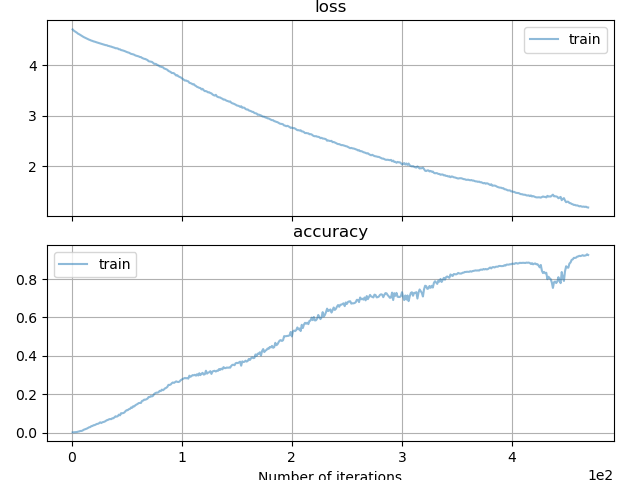

In [9]:
from noggin import create_plot
import matplotlib
%matplotlib notebook
plotter, fig, ax = create_plot(metrics=['loss', 'accuracy'], last_n_batches=1000)

In [10]:
def accuracy(predictions, truth):
    return np.mean((torch.argmax(predictions, dim=1) == truth).cpu().numpy())

In [11]:
batch_size = 64
epochs = 200

for e in range(epochs):
    index = np.arange(len(network_input))
    np.random.shuffle(index)
    
    loss = None
    for batch in range(0, len(network_input), batch_size):
        
        batch_indices = index[batch:batch+batch_size]
        x_train = network_input[batch_indices]
        y_train = network_output[batch_indices]
        
        train_data = torch.tensor(x_train, dtype=torch.float32, device='cuda').to(device)
        test_data = torch.tensor(y_train, dtype=torch.long, device='cuda').to(device)
        
        y_pred = model(train_data)
        loss = nn.functional.cross_entropy(y_pred, test_data)
        acc = accuracy(y_pred, test_data)
        loss.backward()
        optim.step()
        
        plotter.set_train_batch({"loss" : loss.item(), "accuracy" : acc}, batch_size=batch_size)
        
    plotter.set_train_epoch()
    
    
    torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': loss,
            }, '././combined.tar')
    if e % 5 == 0:
        print("EPOCH: ", e)
plotter.plot()

KeyboardInterrupt: 

In [ ]:
'''checkpoint = torch.load('././checkpoint.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()'''

In [18]:
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []
# generate 500 notes

for note_index in range(500):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    
    prediction = model(torch.tensor(prediction_input, dtype=torch.float32, device='cuda'))
    index = np.argmax(prediction.cpu().detach())
    result = int_to_note[index.item()]
    
    prediction_output.append(result)
    pattern = np.append(pattern, index)
    pattern = pattern[1:len(pattern)]
    
print(pattern.shape)

(100,)


In [19]:
offset = 0
output_notes = []# create note and chord objects based on the values generated by the model
for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [20]:
from music21 import stream
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='output.mid')

'output.mid'

In [21]:
import pygame
def play_music(midi_filename):
    clock = pygame.time.Clock()
    pygame.mixer.music.load(midi_filename)
    pygame.mixer.music.play()
    while pygame.mixer.music.get_busy():
        clock.tick(30)
    
midi_filename = 'output.mid'

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [22]:
freq = 44100  # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2  # 1 is mono, 2 is stereo
buffer = 1024   # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)

# optional volume 0 to 1.0
pygame.mixer.music.set_volume(0.8)

try:
  # use the midi file you just saved
    play_music(midi_filename)
except KeyboardInterrupt:
  # if user hits Ctrl/C then exit
  # (works only in console mode)
    pygame.mixer.music.fadeout(1000)
    pygame.mixer.music.stop()